# Troubleshooting Web apps with Python and Pandas

Konrad Brodzik

20 April 2023

## Introduction

Data analysis tutorials usually fail to show how much work is required to get data into a digestable format.

We will be trying to root cause a performance problem in a distributed Web application.

The following case study is based on a real issue we've had with one of our applications. The logs, commits and performance data are artificially generated to meet confidentiality requirements.

This will be a live demo, but here's a link to the data and some setup instructions if you'd like to follow along: https://github.com/Kondziowy/data-analysis-workshop

While this will not be an in-depth class about Python, Pandas or Web apps, I will be happy to answer your questions :)

### Problem statement

Sally: "The website is loading slowly, can you fix it?"

Me: "What do you mean?"

Sally: "Umm, it loads slower than yesterday"

### App - description

- Web application - internal document management system
- 200 daily active users

![System diagram](img\system-diagram.png "Diagram" )

TODO: Add Github, have 2 front ends instead

### Our goals

1. Parse data that's available to us
1. De-noise the data
2. Have a quantitative measure of what's going wrong
3. Correlate different sources of data to find out the root cause of the problem
4. Aggregate data so we can use it for future failure detection

## Front End

What does it do? Serves static files (Javascript, images), forwards other requests to Gunicorn (reverse proxy).

Example log (a.k.a. access log):
```
127.0.0.1 - - [01/Apr/2023:11:27:40 +0000] "GET /index.html HTTP/1.1" 200 1200 0.002617
127.0.0.1 - - [01/Apr/2023:11:27:45 +0000] "GET /images/logo.png HTTP/1.1" 200 15734 0.007353
127.0.0.1 - - [01/Apr/2023:11:28:10 +0000] "POST /login HTTP/1.1" 302 - 0.014992
127.0.0.1 - - [01/Apr/2023:11:29:05 +0000] "GET /dashboard HTTP/1.1" 200 4369 0.100576
127.0.0.1 - - [01/Apr/2023:11:30:20 +0000] "GET /orders HTTP/1.1" 200 3520 0.006817
```

Information found here: request source, date, HTTP method, URL, protocol, response code, response size, processing time

### Parsing Front End logs

- Python find and split
- Regular Expressions
- Dedicated library

#### Find and split
1. Works for simple cases
2. Usually fast
3. Can be tricky to read and breaks easily

In [15]:
example_line = "127.0.0.1 - - [01/Apr/2023:11:27:40 +0000] \"GET \/index.html HTTP\/1.1\" 200 1200 0.002617"
entry_time = example_line[example_line.find("[") + 1:example_line.find("]")]
print(entry_time)

01/Apr/2023:11:27:40 +0000


#### Regular Expressions
1. Slightly higher learning curve
2. Full line matching validates if data is what you expect it to be
3. There are tools to help you - https://regex101.com/ or ChatGPT

In [18]:
import re
from collections import defaultdict

log_file = open('apache.log.big4', 'r')  # replace with the path to your log file

log_pattern = re.compile(
    r'(?P<IP>\d+\.\d+\.\d+\.\d+)\s-\s-\s\[(?P<Date>.*?)\]\s\"(?P<Method>POST|GET) (?P<Request>.*?) HTTP/1.1\"\s(?P<StatusCode>\d+)\s(?P<DataSize>\d+)\s(?P<RequestTime>.*?)$')

data_by_column = defaultdict(list)
lines_matched = 0
for idx, line in enumerate(log_file):
    match = log_pattern.match(line)
    if match is None:
        continue  # skip lines that don't match the pattern
    lines_matched += 1
    for column, value in match.groupdict().items():
        data_by_column[column].append(value)
print(f"Read {lines_matched} lines")
# print(idx)
# assert lines_matched == idx
log_file.close()

Read 450330 lines


### What to do next?

We need:
1. Aggregations - grouping, counting, averages
2. Extensibility - we will be adding more data from other sources

What tools could we use?

In [19]:
import pandas as pd

front_end_requests = pd.DataFrame(
  data_by_column
)
print(front_end_requests.shape)
print(front_end_requests.columns)
print(front_end_requests.info())
print(front_end_requests.Request.unique())
front_end_requests.head()

(450330, 7)
Index(['IP', 'Date', 'Method', 'Request', 'StatusCode', 'DataSize',
       'RequestTime'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450330 entries, 0 to 450329
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   IP           450330 non-null  object
 1   Date         450330 non-null  object
 2   Method       450330 non-null  object
 3   Request      450330 non-null  object
 4   StatusCode   450330 non-null  object
 5   DataSize     450330 non-null  object
 6   RequestTime  450330 non-null  object
dtypes: object(7)
memory usage: 24.1+ MB
None
['/static/bootstrap.min.js' '/reviews?document_id=X' '/static/favicon.ico'
 '/' '/static/images/logo.png' '/document?id=X' '/users'
 '/static/style.css' '/static/jquery-3.3.1.slim.min.js'
 '/documents?page=X&per_page=Y&filter=Z']


,IP,Date,Method,Request,StatusCode,DataSize,RequestTime
0,192.168.129.99,02/Apr/2020:08:00:02 +0000,GET,/static/bootstrap.min.js,200,64733,0.207
1,192.168.35.8,02/Apr/2020:08:00:02 +0000,GET,/static/bootstrap.min.js,500,8467,0.764
2,192.168.10.22,02/Apr/2020:08:00:02 +0000,GET,/reviews?document_id=X,200,42002,0.393
3,192.168.149.158,02/Apr/2020:08:00:02 +0000,GET,/static/favicon.ico,200,38481,0.847
4,192.168.188.102,02/Apr/2020:08:00:02 +0000,GET,/,200,22260,0.573


### Figuring out the requests

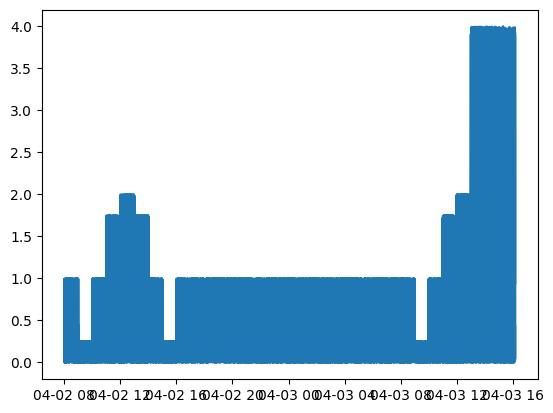

In [7]:
import matplotlib.pyplot as plt

# Not great but shows something
plt.plot(front_end_requests.Date, front_end_requests["RequestTime"])

In [12]:
# front_end_requests.info()
# https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
# 'T' is for minutes, 'S' for seconds
grouped_requests = front_end_requests.groupby(['Request', pd.Grouper(key='Date', axis=0, freq='T')]).count()
grouped_requests.head()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [20]:
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
front_end_requests['Date'] = pd.to_datetime(front_end_requests['Date'], format="%d/%b/%Y:%H:%M:%S %z")
front_end_requests['RequestTime'] = pd.to_numeric(front_end_requests['RequestTime'])
front_end_requests.info()
# https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
# 'T' is for minutes, 'S' for seconds
grouped_requests = front_end_requests.groupby(['Request', pd.Grouper(key='Date', axis=0, freq='T')]).count()
grouped_requests.head()
# grouped_requests.index.get_level_values('Date')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450330 entries, 0 to 450329
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   IP           450330 non-null  object             
 1   Date         450330 non-null  datetime64[ns, UTC]
 2   Method       450330 non-null  object             
 3   Request      450330 non-null  object             
 4   StatusCode   450330 non-null  object             
 5   DataSize     450330 non-null  object             
 6   RequestTime  450330 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(5)
memory usage: 24.1+ MB


IP  Method  StatusCode  DataSize  \
Request Date                                                          
/       2020-04-02 08:00:00+00:00  28      28          28        28   
        2020-04-02 08:01:00+00:00  17      17          17        17   
        2020-04-02 08:02:00+00:00  26      26          26        26   
        2020-04-02 08:03:00+00:00  28      28          28        28   
        2020-04-02 08:04:00+00:00  23      23          23        23   

                                   RequestTime  
Request Date                                    
/       2020-04-02 08:00:00+00:00           28  
        2020-04-02 08:01:00+00:00           17  
        2020-04-02 08:02:00+00:00           26  
        2020-04-02 08:03:00+00:00           28  
        2020-04-02 08:04:00+00:00           23

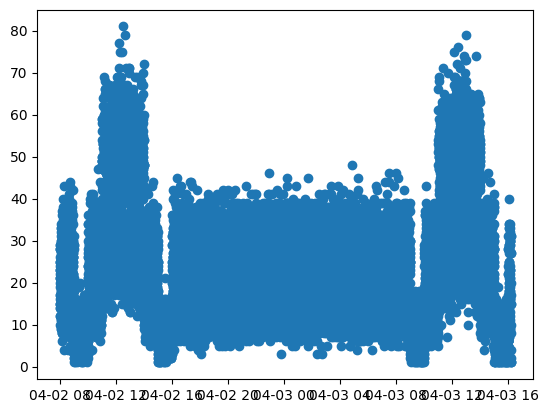

In [4]:
# grouped_requests.index.get_level_values('Date')
# Subsequent keys in a MultiIndex are called levels - https://pandas.pydata.org/docs/reference/api/pandas.MultiIndex.html
plt.plot(grouped_requests.index.get_level_values('Date'), grouped_requests['StatusCode'], 'o')
# TODO: add labels, improve date formatting
# TODO: explore individual vs vector multiplication in panadas

In [21]:
all_means = front_end_requests.groupby(['Request', pd.Grouper(key='Date', axis=0, freq='T')])['RequestTime'].mean()
all_means.head()
# TODO: use to replace /static with static content
# all_means.index.where()
# Get
# front_end_requests['Request'].unique()
# X axis
# all_means.filter(like='/users').index.get_level_values('Date')
# TODO: figure out better way


Request  Date                     
/        2020-04-02 08:00:00+00:00    0.471571
         2020-04-02 08:01:00+00:00    0.506059
         2020-04-02 08:02:00+00:00    0.573846
         2020-04-02 08:03:00+00:00    0.476750
         2020-04-02 08:04:00+00:00    0.531435
Name: RequestTime, dtype: float64

FIXME: / won't work with like operator


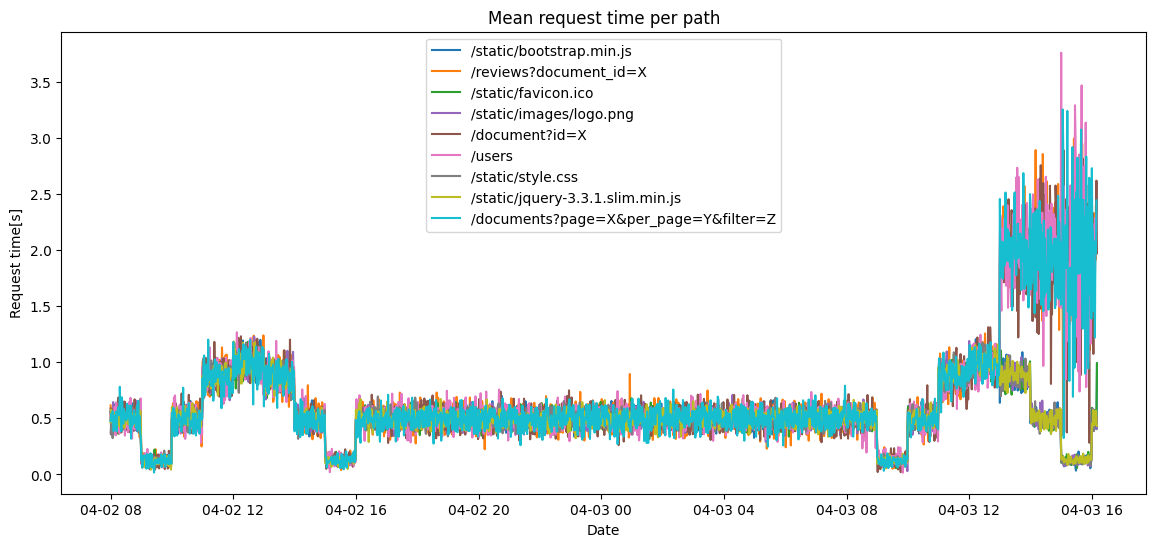

In [40]:
import matplotlib.dates
plt.figure(figsize=(14,6))
for idx, server_path in enumerate(front_end_requests['Request'].unique()):
    if server_path == '/':
        print("FIXME: / won't work with like operator")
        continue
    # https://datatofish.com/filter-pandas-dataframe/
    x_axis = all_means.filter(like=server_path).index.get_level_values('Date')
    y_axis = all_means.filter(like=server_path)
    # print(server_path)
    # print(x_axis)
    # print(y_axis)
    # https://matplotlib.org/stable/gallery/color/color_demo.html#sphx-glr-gallery-color-color-demo-py
    plt.plot(x_axis, y_axis, color=f"C{idx}", label=server_path)
plt.title("Mean request time per path")
plt.legend(loc="upper center")
plt.xlabel("Date")
plt.ylabel("Request time[s]")

plt.show()

### Saving your intermediate results

In [28]:
pd.to_pickle(all_means, "front_end_mean_times.pickle")
print(all_means.shape)
means_restored = pd.read_pickle("front_end_mean_times.pickle")
print(means_restored.shape)
all_means.to_csv("front_end_mean_times.csv")

(124,)
(124,)


### Front end logs - summary

- With text logs, there are different ways to parse them
- Regular expressions are a good solution in many cases but always consider your options
- We know API request times have increased in the afternoon of April 3, what do we do next?

## Back End

What does it do? Processes business logic, handles database communication. This is where your Flask, Django, FastAPI or Node.js application runs.

Example log:
```
[2022-04-01 13:37:00 +0000] [12345] [ellen] [api.py:85] [INFO] GET /documents?page=X&per_page=Y&filter=Z 200 3520 0.006817
[2022-04-01 13:37:00 +0000] [12345] [] [api.py:86] [INFO] Recording operation GET from user ellen
[2022-04-01 13:37:00 +0000] [12345] [ellen] [api.py:85] [INFO] GET /users 200 3128 0.006817
```

Information here will largerly overlap with what we get from Nginx so let's just skip it.

## Database

Read & writes data. Our example focuses on PostgreSQL internals but the same reasoning can be applied to any other database engine.

**Note**: PostgreSQL only serves current data in the `pg_stat_all_tables` view. We will be using a time series that has to be collected using other tools - e.g. Zabbix or Prometheus. For the sake of this excercise, assume we have a script that outputs the result of this query every 5 seconds to an Sqlite database.

In [1]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('tps_database.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

In [2]:
db_stats = pd.read_sql("SELECT * FROM db_activity", conn)

In [3]:
db_stats.head()
db_stats['timestamp'] = pd.to_datetime(db_stats['timestamp'], format="%Y-%m-%d %H:%M:%S.000")
db_stat_means = db_stats.groupby(['table_name', pd.Grouper(key='timestamp', axis=0, freq='T')])['tuples_read', 'tuples_write'].mean()
db_stat_means.head()
print(db_stat_means.columns)
print(db_stat_means.index)
print(db_stat_means["tuples_read"].filter(like="audit_log"))


Index(['tuples_read', 'tuples_write'], dtype='object')
MultiIndex([('audit_log', '2020-04-03 13:00:00'),
            ('audit_log', '2020-04-03 13:01:00'),
            ('audit_log', '2020-04-03 13:02:00'),
            ('audit_log', '2020-04-03 13:03:00'),
            ('audit_log', '2020-04-03 13:04:00'),
            ('audit_log', '2020-04-03 13:05:00'),
            ('audit_log', '2020-04-03 13:06:00'),
            ('audit_log', '2020-04-03 13:07:00'),
            ('audit_log', '2020-04-03 13:08:00'),
            ('audit_log', '2020-04-03 13:09:00'),
            ...
            (    'users', '2020-04-03 16:01:00'),
            (    'users', '2020-04-03 16:02:00'),
            (    'users', '2020-04-03 16:03:00'),
            (    'users', '2020-04-03 16:04:00'),
            (    'users', '2020-04-03 16:05:00'),
            (    'users', '2020-04-03 16:06:00'),
            (    'users', '2020-04-03 16:07:00'),
            (    'users', '2020-04-03 16:08:00'),
            (    'users', '20

C:\Users\gnuri\AppData\Local\Temp\ipykernel_25800\3230038208.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  db_stat_means = db_stats.groupby(['table_name', pd.Grouper(key='timestamp', axis=0, freq='T')])['tuples_read', 'tuples_write'].mean()


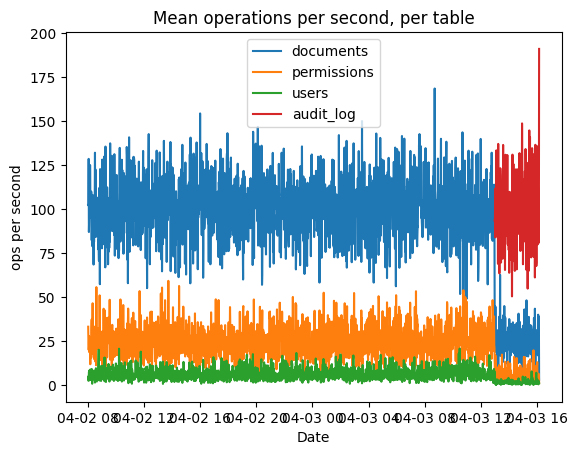

In [4]:
import matplotlib.pyplot as plt

for idx, table_name in enumerate(db_stats.table_name.unique()):
    # https://datatofish.com/filter-pandas-dataframe/
    x_axis = db_stat_means["tuples_read"].filter(like=table_name).index.get_level_values('timestamp')
    y_axis = db_stat_means["tuples_read"].filter(like=table_name)
    # https://matplotlib.org/stable/gallery/color/color_demo.html#sphx-glr-gallery-color-color-demo-py
    plt.plot(x_axis, y_axis, color=f"C{idx}", label=table_name)
plt.title("Mean operations per second, per table")
plt.legend(loc="upper center")
plt.xlabel("Date")
plt.ylabel("ops per second")

plt.show()

## Github

Github is used to deploy new versions of our system. For the sake of simplicity, let's assume commits get deployed to production immediately after being pushed to Git.

In [7]:
import json
import pprint

# https://docs.github.com/en/rest/commits/commits?apiVersion=2022-11-28
# url = f"https://api.github.com/repos/{owner}/{repo_name}/commits?sha={branch}"
# response = requests.get(url, headers=headers)
with open("data/github-output.json") as f:
    response = json.load(f)

# pprint.pprint(response)


In [9]:
messages_dates = {"Date": [], "Message": []}
for commit in response:
    print(f"Commit SHA: {commit['sha']}, Message: {commit['commit']['message']}, Date: {commit['commit']['author']['date']}")
    messages_dates["Date"].append(commit['commit']['author']['date'])
    messages_dates["Message"].append(commit['commit']['message'])


Commit SHA: 87c5efe0f524f68e827cc970947dd245cef24ae8, Message: Merge pull request #2 from legoGoat/choosing-stuff

Choosing stuff, Date: 2020-04-03T14:02:16Z
Commit SHA: 6353805000ff4123ee8999948f252ebd9bd26b6f, Message: Introduce audit log functionality, Date: 2020-04-03T12:41:51Z
Commit SHA: 5fc440fd1ee707d99b0bf2e25a08b6517cc326d1, Message: chyba działa :thonk:, Date: 2020-04-03T10:22:30Z
Commit SHA: 0d72ead2822a8a92236938aa54903bd32f1645be, Message: chyba działa :thonk:, Date: 2020-04-03T10:19:13Z
Commit SHA: f3b69ba1b74fcd4115973bfe2dbacbd924fa8bf2, Message: Merge pull request #1 from Kondziowy/fix_bad_uris

Only return correct URLs, Date: 2020-01-07T18:33:09Z
Commit SHA: 78ea3835e70d7704ae6495c26b63f95e7aefb573, Message: Only return correct URLs, Date: 2020-01-07T18:19:47Z
Commit SHA: a4ef7266cc138cd4c4eb8fd919e4dea3ef3e2f59, Message: Merge branch 'main' of github.com:Kondziowy/document-management-system, Date: 2020-01-07T17:22:26Z
Commit SHA: 26e0a42aac9ae734392a6458c90cdb52fc08

### Bringing it all together



In [41]:
# https://stackoverflow.com/questions/11067368/annotate-time-series-plot-in-matplotlib
# https://matplotlib.org/stable/tutorials/text/annotations.html#annotating-data

commits_pd = pd.DataFrame(
  messages_dates
)
commits_pd.head()

# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
commits_pd['Date'] = pd.to_datetime(commits_pd['Date'], format="%Y-%m-%dT%H:%M:%S%Z")
commits_per_minute = commits_pd.groupby([pd.Grouper(key='Date', axis=0, freq='T')]).last()
commits_per_minute.head()
# commits_per_minute.shape
commits_per_minute.loc['2020-04-03 12:41:00+00:00']

Message    Introduce audit log functionality
Name: 2020-04-03 12:41:00+00:00, dtype: object

In [39]:
unstacked_requests = all_means.unstack(0)
requests_commits = unstacked_requests.join(commits_per_minute)
# requests_commits.loc['2020-04-03 12:42:00+00:00']


/                                        1.236975
/document?id=X                            1.19619
/documents?page=X&per_page=Y&filter=Z    1.179654
/reviews?document_id=X                   0.980467
/static/bootstrap.min.js                 1.152915
/static/favicon.ico                      0.998962
/static/images/logo.png                  1.045203
/static/jquery-3.3.1.slim.min.js         1.008647
/static/style.css                        0.941212
/users                                   0.993174
Message                                      None
Name: 2020-04-03 12:42:00+00:00, dtype: object

FIXME: / won't work with like operator
Date 2020-04-03 10:19:00+00:00 found
Date 2020-04-03 10:22:00+00:00 found
Date 2020-04-03 12:41:00+00:00 found
Date 2020-04-03 14:02:00+00:00 found


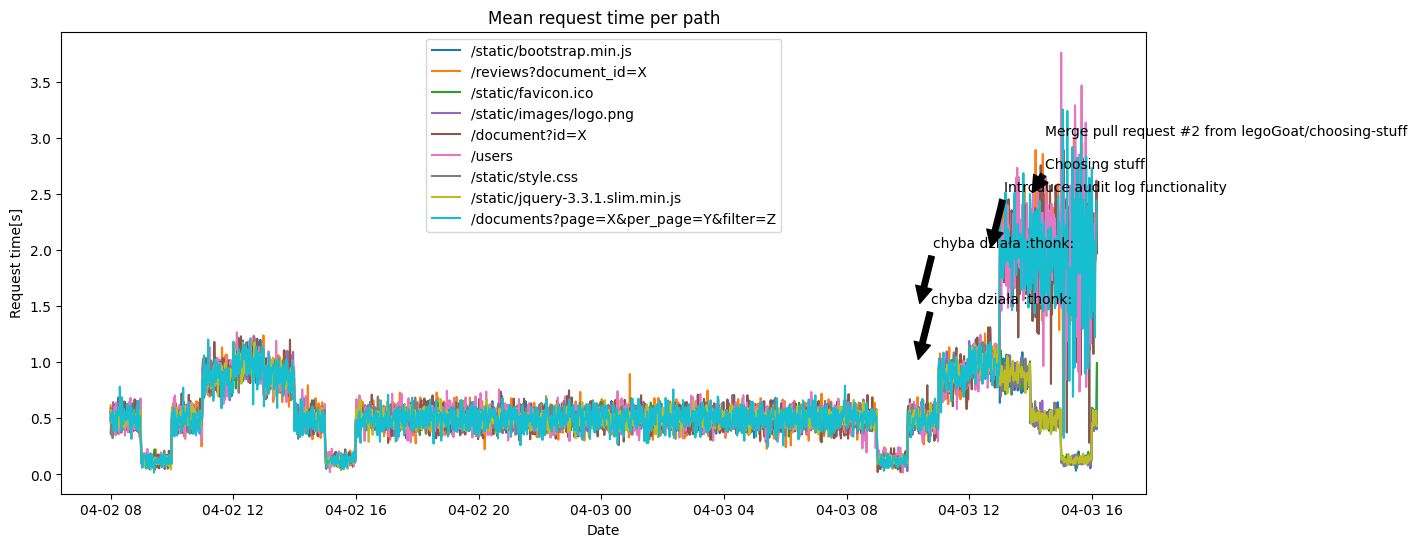

In [52]:
plt.figure(figsize=(14,6))
for idx, server_path in enumerate(front_end_requests['Request'].unique()):
    if server_path == '/':
        print("FIXME: / won't work with like operator")
        continue
    # https://datatofish.com/filter-pandas-dataframe/
    x_axis = all_means.filter(like=server_path).index.get_level_values('Date')
    y_axis = all_means.filter(like=server_path)
    # https://matplotlib.org/stable/gallery/color/color_demo.html#sphx-glr-gallery-color-color-demo-py
    plt.plot(x_axis, y_axis, color=f"C{idx}", label=server_path)
plt.title("Mean request time per path")
plt.legend(loc="upper center")
plt.xlabel("Date")
plt.ylabel("Request time[s]")

label_y = 1
for date in all_means.filter(like=server_path).index.get_level_values('Date'):
    if date in requests_commits.index and requests_commits.loc[date].Message:
        try:
            requests_commits.loc[date].Message.isascii()
            print(f"Date {date} found")
            plt.annotate(requests_commits.loc[date].Message, xy=(date, label_y), xycoords='data', xytext=(10, 50), textcoords='offset points', va='top', ha='left', arrowprops=dict(facecolor='black', shrink=0.05))
            label_y += 0.5
        except:
            pass

plt.show()

FIXME: / won't work with like operator


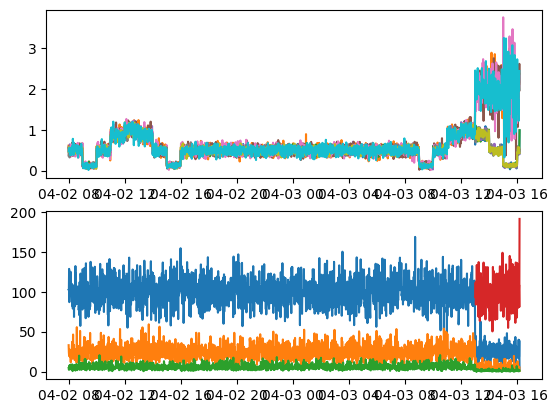

In [58]:
fig = plt.figure()

# subplot has 2 rows and 2 columns, plot location 1
axes1 = fig.add_subplot(2, 1, 1)
# subplot has 2 rows and 2 columns, plot location 2
axes2 = fig.add_subplot(2, 1, 2)

# plt.figure(figsize=(14,6))
for idx, server_path in enumerate(front_end_requests['Request'].unique()):
    if server_path == '/':
        print("FIXME: / won't work with like operator")
        continue
    # https://datatofish.com/filter-pandas-dataframe/
    x_axis = all_means.filter(like=server_path).index.get_level_values('Date')
    y_axis = all_means.filter(like=server_path)
    # https://matplotlib.org/stable/gallery/color/color_demo.html#sphx-glr-gallery-color-color-demo-py
    axes1.plot(x_axis, y_axis, color=f"C{idx}", label=server_path)
# axes1.title = "Mean request time per path"
# axes1.legend(loc="upper center")
# axes1.set_xlabel("Date")
# axes1.set_ylabel("Request time[s]")

for idx, table_name in enumerate(db_stats.table_name.unique()):
    # https://datatofish.com/filter-pandas-dataframe/
    x_axis = db_stat_means["tuples_read"].filter(like=table_name).index.get_level_values('timestamp')
    y_axis = db_stat_means["tuples_read"].filter(like=table_name)
    # https://matplotlib.org/stable/gallery/color/color_demo.html#sphx-glr-gallery-color-color-demo-py
    axes2.plot(x_axis, y_axis, color=f"C{idx}", label=table_name)
# axes2.title = "Mean operations per second, per table"
# plt.legend(loc="upper center")
# axes2.set_xlabel("Date")
# axes2.set_ylabel("ops per second")

### Back up - ChatGPT queries used for this presentation

## Further reading

"Pandas for Everyone: Python Data Analysis, First Edition", Daniel Y. Chen, Addison-Wesley 2018 (https://learning.oreilly.com/library/view/pandas-for-everyone/9780134547046/cover.xhtml)